In [31]:
"""
Follow by the PyTorch tutorial:
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
"""
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
def findFiles(path): return glob.iglob(path)

In [32]:
import unicodedata
import string
all_letters = string.ascii_letters
n_letters = len(all_letters)

In [33]:
def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD',s)
    if unicodedata.category(c)!='Mn' and c in all_letters)

In [34]:
category_lines = {}
all_categories = []
def readlines(filename):
    lines = open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
for filename in findFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readlines(filename)
    category_lines[category] = lines

In [35]:
n_categories = len(all_categories)

In [36]:
def letterToIndex(letter):
    return all_letters.find(letter)
def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)]=1
    return tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for index,c in enumerate(line):
        tensor[index][0][letterToIndex(c)]=1
    return tensor

In [37]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
hidden = rnn.initHidden()

In [38]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

sum = 0
for cateClass in all_categories:
    for cateLine in category_lines[cateClass]:
        for cateChar in cateLine:
            sum+=1
            if (sum>100): break
            input = letterToTensor(cateChar)
            output, hidden = rnn.forward(input, hidden)
            print (output)

In [39]:
import random
def randomChoice(Lst):
    return Lst[random.randint(0,len(Lst)-1)]
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.int64)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [40]:
lr = 0.005
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(),lr=lr)
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i],hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)
    #optimizer.step()
    
    return output, loss.item()
    

In [41]:
import time
import math
n_iters = 100000
print_every = 5000 
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(begin):
    now = time.time()
    s = now - begin
    return s
start = time.time()
for iter in range(1,n_iters+1):
    if (iter%1000==0):
        print (iter)
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    if (iter%print_every==0):
        guess, guess_i = categoryFromOutput(output)
        print (iter,timeSince(start),loss)
    if (iter%plot_every==0):
        all_losses.append(current_loss/plot_every)
        current_loss = 0
    

1000
2000
3000
4000
5000
5000 7.090573310852051 2.1468043327331543
6000
7000
8000
9000
10000
10000 14.112395763397217 1.5339996814727783
11000
12000
13000
14000
15000
15000 20.960450410842896 1.532360315322876
16000
17000
18000
19000
20000
20000 27.82626175880432 2.2281713485717773
21000
22000
23000
24000
25000
25000 34.913585901260376 3.1051976680755615
26000
27000
28000
29000
30000
30000 41.848872661590576 0.5405797958374023
31000
32000
33000
34000
35000
35000 48.76732897758484 2.008484363555908
36000
37000
38000
39000
40000
40000 55.591208696365356 0.7736177444458008
41000
42000
43000
44000
45000
45000 62.52577829360962 0.6509284973144531
46000
47000
48000
49000
50000
50000 69.35223770141602 2.373375415802002
51000
52000
53000
54000
55000
55000 76.28531432151794 0.040216922760009766
56000
57000
58000
59000
60000
60000 83.50182676315308 2.4195141792297363
61000
62000
63000
64000
65000
65000 90.45449209213257 0.9730072021484375
66000
67000
68000
69000
70000
70000 97.36274552345276 0.4

In [42]:
print (all_losses)

[2.8643894004821777, 2.8192967729568483, 2.765598227262497, 2.689737408876419, 2.5384959129095077, 2.3911936583518982, 2.344194307923317, 2.3050187628269194, 2.2517122057676313, 2.185966992974281, 2.1626415011882782, 2.0765473383665083, 2.0295476409196853, 1.9703747634887696, 1.9459049736261367, 1.9527948474884034, 1.9463102716207503, 1.883125848531723, 1.8892862062454223, 1.8507020853757858, 1.7923739101886749, 1.8005051971673967, 1.8318849859237671, 1.7355795809030532, 1.7243843474388123, 1.775379772543907, 1.7040767703056336, 1.734689053297043, 1.687893889427185, 1.6184932755231858, 1.6587897423505784, 1.6968554667234421, 1.6432678327560424, 1.6214649506807328, 1.5976131479740143, 1.6234902521371841, 1.5453471617698669, 1.5718742218017578, 1.5038582504987716, 1.5522789602279663, 1.509202474951744, 1.4920276579856873, 1.5723261449337005, 1.537586970090866, 1.476572058916092, 1.5390626094341278, 1.452629992723465, 1.5365760341882706, 1.485903459072113, 1.5039130182266236, 1.4722034268

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


No handles with labels found to put in legend.


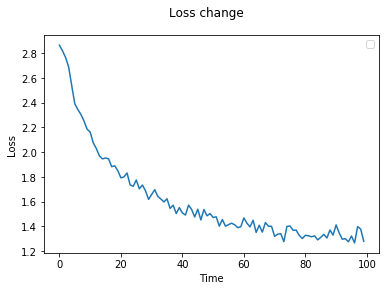

In [44]:
plt.figure()
plt.suptitle("Loss change")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.legend()
plt.plot(all_losses)
plt.show()

In [46]:
confusion=torch.zeros(n_categories,n_categories)
n_confusion = 10000
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    return output
for i in range(n_confusion):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess,guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i]+=1
for i in range(n_categories):
    confusion[i]=confusion[i]/confusion[i].sum()
    


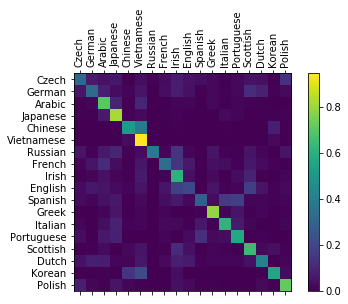

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels(['']+all_categories, rotation=90)
ax.set_yticklabels(['']+all_categories, rotation=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()


In [83]:
def predict(input_line, n_predictions=3):
    print('\n>{}'.format(input_line))
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv,topi=output.topk(n_predictions,1,True)
        print (topv,topi)
        predictions=[]
        for i in range(n_predictions):
            value=topv[0][i].item()
            category_index=topi[0][i].item()
            print('{}'.format(all_categories[category_index]))

predict('Kiyomaru')


>Kiyomaru
tensor([[-0.0251, -4.0837, -6.0834]]) tensor([[ 3,  2, 15]])
Japanese
Arabic
Dutch
